1.    Use numpy or scipy to generate a (uneven) bimodal distribution with some Gaussian noise. This will give us a slightly difficult distribution to try to predict.
2.    Plot this distribution of points as well as the true underlying distribution.
3.  Using an OLS regression with scikit-learn, fit a single line to your data. With a small holdout of data what is the SSE error?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

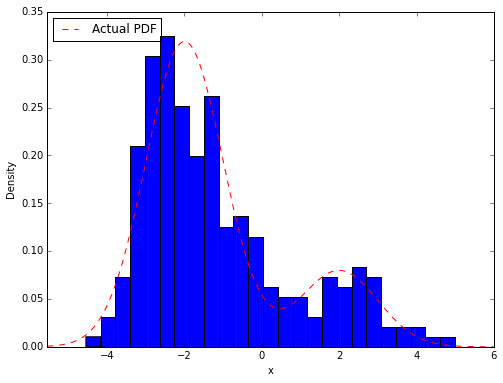

In [75]:
loc1, scale1, size1 = (-2, 1, 200)
loc2, scale2, size2 = (2, 1, 50)
x2 = np.concatenate([np.random.normal(loc=loc1, scale=scale1, size=size1),
                      np.random.normal(loc=loc2, scale=scale2, size=size2)])

x_eval = np.linspace(x2.min() - 1, x2.max() + 1, 250)
pdf = stats.norm.pdf
bimodal_pdf = pdf(x_eval, loc=loc1, scale=scale1) * float(size1) / x2.size + \
                pdf(x_eval, loc=loc2, scale=scale2) * float(size2) / x2.size

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_eval, bimodal_pdf, 'r--', label="Actual PDF")
ax.hist(x2, 25, normed=True)

ax.set_xlim([x_eval.min(), x_eval.max()])
ax.legend(loc=2)
ax.set_xlabel('x')
ax.set_ylabel('Density')
plt.show()

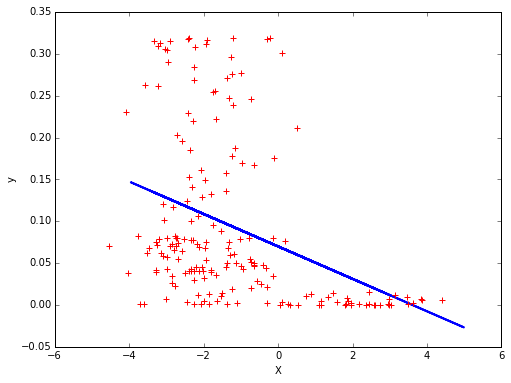

0.416145998964


In [100]:
LR = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(x2.reshape(len(x2),1), bimodal_pdf.reshape(len(bimodal_pdf),1),
                                                    random_state=42)

LR.fit(X_train, y_train)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(X_test, LR.predict(X_test), linewidth=2, color='blue')
ax.scatter(X_train, y_train, s=30, c='r', marker='+', zorder=10)

ax.set_xlabel('X')
ax.set_ylabel('y')
plt.show()
SSE = np.sum((y_test-LR.predict(X_test))**2)
print SSE

4.  Now, (using an OLS regression again), create a Bagged ensemble of 50 models. For the prediction simply average the prediction of each individual regression line.
5.  Again with a small holdout, what is the SSE of the ensemble? Has bagging improved the error?
6.  Plot each of the 50 fitted lines of the regression on top of your above plot of the underlying data distribution.

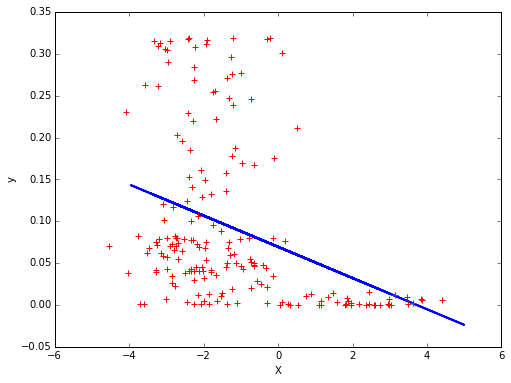

0.409635656597


In [101]:
LR1 = linear_model.LinearRegression()
LRBR = BaggingRegressor(LR1,50)

X_train, X_test, y_train, y_test = train_test_split(x2.reshape(len(x2),1), bimodal_pdf.reshape(len(bimodal_pdf),),
                                                   random_state=42)

LRBR.fit(X_train, y_train)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(X_test, LRBR.predict(X_test), linewidth=2, color='blue')
ax.scatter(X_train, y_train, s=30, c='r', marker='+', zorder=10)

ax.set_xlabel('X')
ax.set_ylabel('y')
plt.show()
SSE = np.sum((y_test-LRBR.predict(X_test))**2)
print SSE

7.  Now we will use a Decision Tree regressor. Perform the same steps #3-6. Is the bagged ensemble of trees give a lower error? Why do you think this works for the trees?

8.  Create a separate plot of the following as a function of X (your single feature) for both the single decision tree as well as the decision tree ensemble:
        total error
        bias-squared
        variance
        original Gaussian noise

9.  What do you notice about the single decision tree compared to the ensemble?
10. Repeat the above plot for a few other classifiers and compare. Which classifiers does ensembling help? Which ones does ensembling have minimal effect on?

Tree: 1.9872 (error) = 0.0185 (bias^2)  + 0.9718 (var) + 0.9761 (noise)
Bagging(Tree): 1.5264 (error) = 0.0081 (bias^2)  + 0.5210 (var) + 0.9761 (noise)


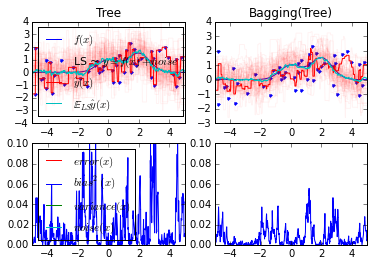

In [105]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 1         # Standard deviation of the noise
np.random.seed(0)

estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

plt.show()